# INFORMASI
Ini adalah proses cleaning dan penyiapan data komentar Twitter yang diperoleh dari Kaggle untuk dipergunakan sebagai target domain data. Output dari code ini adalah csv yang berisi kalimat hasil preprocessing yang disesuaikan untuk BERT dan DL/ML. Process preprocess data Twitter ini juga yang menjadi acuan untuk preprocess data YouTube nanti.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import re
import string
import html
import unicodedata
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import stanza

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')
import random

In [2]:
df = pd.read_csv('data/normalize_text_twitter.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           13169 non-null  object
 1   cyberbullying  13169 non-null  int64 
 2   text_expanded  13169 non-null  object
dtypes: int64(1), object(2)
memory usage: 308.8+ KB


In [3]:
df.head()

,text,cyberbullying,text_expanded
0,- disaat semua cowok berusaha melacak perhatia...,1,- di saat semua cowok berusaha melacak perhati...
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,RT PENGGUNA: PENGGUNA siapa yang telat memberi...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,"41. Kadang aku berpikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,PENGGUNA PENGGUNA AKU ITU AKU\dan\ku TAU MATAM...
4,USER USER Kaum cebong kapir udah keliatan dong...,1,PENGGUNA PENGGUNA Kaum cebong kafir sudah keli...


In [4]:
df['text'] = df['text_expanded']
df = df.drop(columns=['text_expanded'], axis = 1)
df.head()

,text,cyberbullying
0,- di saat semua cowok berusaha melacak perhati...,1
1,RT PENGGUNA: PENGGUNA siapa yang telat memberi...,0
2,"41. Kadang aku berpikir, kenapa aku tetap perc...",0
3,PENGGUNA PENGGUNA AKU ITU AKU\dan\ku TAU MATAM...,0
4,PENGGUNA PENGGUNA Kaum cebong kafir sudah keli...,1


# EDA

In [5]:
df['cyberbullying'].value_counts()

cyberbullying
0    7608
1    5561
Name: count, dtype: int64

Target labelnya hanya sedikit imbalanced. Oleh karena itu, penanganan imbalance nantinya cukup dilakukan dengan metode sederhana, misalnya dengan mengaktifkan parameter class_weight menjadi 'balanced'.

In [6]:
print("duplicated columns: ", df['text'].duplicated().sum())
dups = df[df['text'].duplicated(keep=False)].sort_values("text")
dups

duplicated columns:  152


,text,cyberbullying
295,#Gubernur zaman now #Gus ipul puti 2 #Ganjar y...,0
378,#Gubernur zaman now #Gus ipul puti 2 #Ganjar y...,0
43,#Gubernur zaman now #Gus ipul puti 2 #Ganjar y...,0
4254,#Gubernur zaman now #Gus ipul puti 2 #Ganjar y...,0
10254,#Gubernur zaman now #Gus ipul puti 2 #Ganjar y...,0
...,...,...
382,"perempuan kayak kamu mending mati saja deh, je...",1
8544,tangkap ahok dan kelompok nya yang melakukan p...,1
5182,tangkap ahok dan kelompok nya yang melakukan p...,1
11964,"~; Yang jelas, kalau ada foto foto yang begitu...",0


Terdapat 152 kolom duplikat, perlu dihapus

In [7]:
df = df.drop_duplicates(subset='text').reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13017 entries, 0 to 13016
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           13017 non-null  object
 1   cyberbullying  13017 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 203.5+ KB


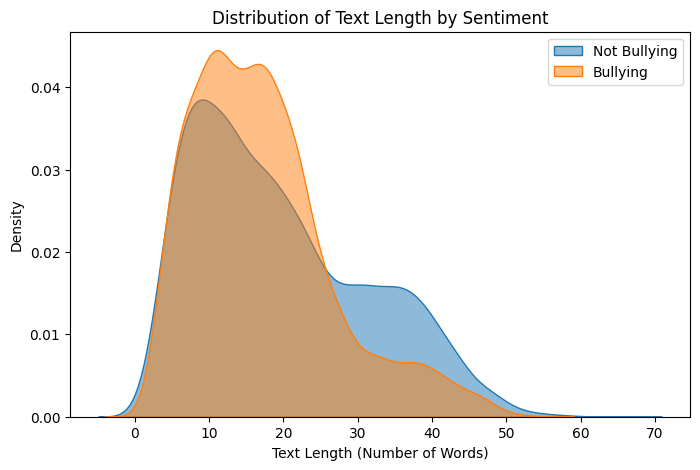

In [8]:
df['length'] = df['text'].apply(lambda x: len(x.split()))

not_bully = df.loc[df['cyberbullying'] == 0]
bully = df.loc[df['cyberbullying'] == 1]

plt.figure(figsize=(8, 5))

sns.kdeplot(not_bully['length'], fill=True, label='Not Bullying', alpha=0.5)
sns.kdeplot(bully['length'], fill=True, label='Bullying', alpha=0.5)

plt.title('Distribution of Text Length by Sentiment')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [9]:
summary = pd.DataFrame({
    'Not Bullying': not_bully['length'].describe(),
    'Bullying' : bully['length'].describe()
})

summary

,Not Bullying,Bullying
count,7516.000000,5501.000000
mean,19.648350,17.088348
std,11.770344,9.535094
min,1.000000,1.000000
25%,10.000000,10.000000
50%,17.000000,16.000000
75%,28.000000,22.000000
max,65.000000,54.000000


Berdasarkan nilai statistik, kedua kategori 'Not Bullying' dan 'Bullying' memiliki karakteristik yang cukup mirip. Rata rata untuk kelas Not Bullying adalah 19, sedangkan untuk Bullying berada di angka 17,1. Perbedaan standar deviasi juga tidak terlalu jauh, yakni sekitar 11 untuk Not Bullying dan 9 untuk Bullying. Nilai kuartil 1 dan median pada kedua kelas pun serupa, masing-masing berada di kisaran 9 dan 17–16. Namun, kuartil 3 pada kelas Not Bullying terlihat lebih tinggi, menunjukkan bahwa sebaran nilai di kelas ini lebih bervariasi sesuai dengan standar deviasi yang juga lebih besar.

Hipotesis: 
1. Pada umumnya, semakin panjang teks, semakin banyak kata yang tidak penting dan semakin besar probabilitas ada kalimat kontradiktif sehingga model sulit mengekstraksi pattern/sinyal.

2. Pada arsitektur Transformer, self-attention bekerja dengan menghitung attention weight, yaitu seberapa besar sebuah kata perlu memperhatikan kata lain. Nilai-nilai ini dihitung dari similarity score lalu didistribusikan menggunakan softmax. Ketika panjang teks bertambah, jumlah pasangan kata yang harus dibandingkan juga ikut bertambah. Akibatnya, attention weight harus menyebar ke lebih banyak kata. Penyebaran ini membuat perhatian model menjadi lebih luas dan kurang terfokus, sehinggal sinyal penting bisa pudar. 

3. Pada model machine learning tradisional, semakin panjang teks maka semakin banyak kata baru yang muncul. Hal ini membuat ukuran vocabulary bertambah besar. Ketika vocabulary membesar, model harus menangani fitur yang semakin banyak dan semakin jarang muncul. Akibatnya, beberapa kata yang sebenarnya tidak penting bisa terlihat seolah-olah signifikan, terutama jika kita menggunakan representasi seperti TF-IDF. Kata yang jarang muncul bisa memperoleh nilai TF-IDF tinggi hanya karena frekuensinya rendah, padahal kata tersebut tidak memberikan informasi yang benar-benar berguna. Ini dapat membuat model kebingungan dan cenderung overfit. 


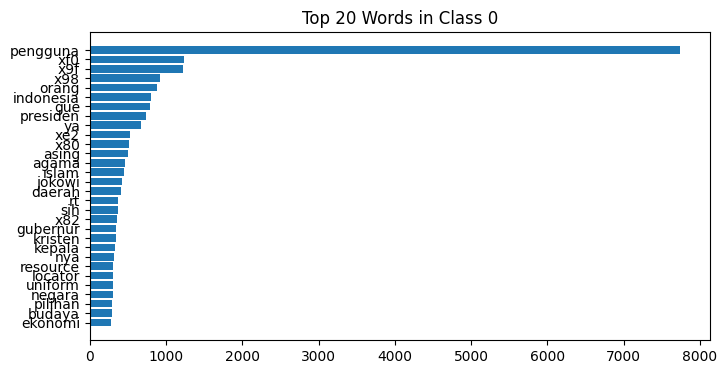

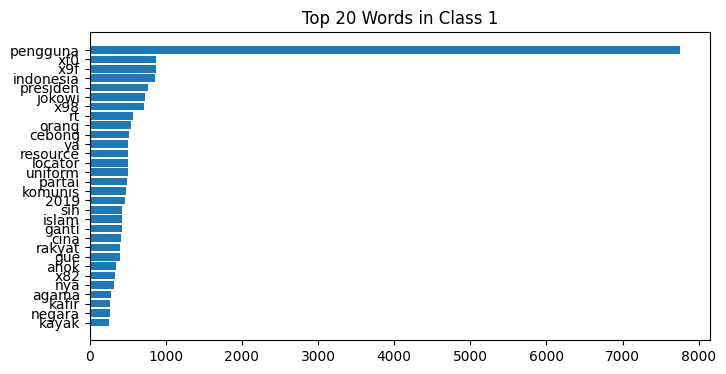

In [10]:
stopwords_id = stopwords.words('indonesian')

for sentiment in sorted(df['cyberbullying'].unique()):
    text = " ".join(df[df['cyberbullying'] == sentiment]['text'])
    
    vectorizer = CountVectorizer(stop_words=stopwords_id)
    X = vectorizer.fit_transform([text])
    freqs = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().flatten()
    }).sort_values('count', ascending=False).head(30)

    plt.figure(figsize=(8,4))
    plt.barh(freqs['word'], freqs['count'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 Words in Class {sentiment}')
    plt.show()

In [11]:
top_words = {} 

for sentiment in sorted(df['cyberbullying'].unique()):
    text = " ".join(df[df['cyberbullying'] == sentiment]['text'])
    
    vectorizer = CountVectorizer(stop_words=stopwords_id)
    X = vectorizer.fit_transform([text])
    
    freqs = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().flatten()
    }).sort_values('count', ascending=False).head(30)

    top_words[sentiment] = set(freqs['word'])

not_bully = top_words[0]
bully = top_words[1]

# kata yang muncul di kedua label
common_all = not_bully & bully 

# kata yang hanya muncul di masing-masing label saja
unique_non = not_bully - bully
unique_bully  = bully - not_bully

print('Kata dari top 30 yang ada di kedua label: ',common_all)
print('Kata dari top 30 yang ada label Not Bullying saja: ',unique_non)
print('Kata dari top 30 yang ada label Bullying saja: ',unique_bully)


Kata dari top 30 yang ada di kedua label:  {'negara', 'gue', 'locator', 'x98', 'islam', 'ya', 'agama', 'rt', 'orang', 'jokowi', 'indonesia', 'sih', 'uniform', 'x82', 'x9f', 'pengguna', 'nya', 'resource', 'presiden', 'xf0'}
Kata dari top 30 yang ada label Not Bullying saja:  {'xe2', 'x80', 'budaya', 'asing', 'gubernur', 'kristen', 'pilihan', 'kepala', 'ekonomi', 'daerah'}
Kata dari top 30 yang ada label Bullying saja:  {'kayak', 'partai', 'cebong', 'ganti', 'komunis', 'kafir', 'rakyat', '2019', 'ahok', 'cina'}


Berdasarkan daftar top 30 words, terlihat pola yang cukup jelas antara kedua label:

1. Kata yang muncul di kedua label seperti 'jokowi', 'indonesia', 'presiden', 'orang', 'islam, 'gue'. Kata-kata ini merupakan shared vocabulary yang umum dalam percakapan politik atau opini publik. Kemunculan kata tersebut tidak secara langsung menunjukkan indikasi bullying karena konteks penggunaannya bisa netral, positif, maupun negatif. Dengan kata lain, kata-kata ini kurang informatif untuk membedakan kedua kelas.

2. Kata yang muncul hanya pada label Not Bullying—misalnya 'pilihan', 'daerah', 'kristen', 'asing', 'ekonomi', 'gubernur', 'budaya', 'kepala', cenderung bersifat informatif atau deskriptif. Kata-kata ini bersifat informatif atau deskriptif dan biasanya digunakan dalam diskusi, berita, atau opini sosial-politik yang bersifat netral. Tidak ada unsur penyerangan terhadap individu atau kelompok tertentu, sehingga sesuai dengan karakteristik teks yang tidak mengandung cyberbullying.

3. Sebaliknya, kata yang muncul hanya pada label Bullying seperti 'rakyat', 'kafir', 'partai', '2019', 'ganti', 'ahok', 'cebong', 'cina', 'komunis', 'kayak', menunjukkan pola bahasa yang bersifat menyerang, merendahkan, atau diskriminatif. Kata-kata ini jelas mengarah pada penghinaan berbasis ras, agama, politik, figur tertentu yang dibenci pada tahun tersebut seperti Pak Ahok. 

Selain itu, pada bar plot muncul kata-kata yang tidak bermakna seperti USER (hasil normalisasi mention pada tweet), serta token aneh berupa kode byte seperti 'x82', 'x98', dan sebagainya. Token-token ini tidak memiliki makna dan dapat mengganggu model dalam membedakan kelas. Oleh karena itu, kata-kata seperti ini perlu dihapus nantinya. 

# 2. Cleaning

In [ ]:
weird_texts = df[df['text'].apply(lambda x: bool(re.search(r'[^\x00-\x7F]', str(x))))]

print('Kata bukan ASCII: \n', weird_texts['text'].unique())
print('\nJumlah kalimat: ', weird_texts['text'].nunique())

Kata bukan ASCII: 
 ['Nah admin belanja satu lagi port terbaik nak makan Ais Kepal Milo, Ais Kepal Horlicks atau Cendol Toping kau kau. ð??\xad; ; Doket mana itu ? Gerai Rozak Mertuaku - Taipan 2 (depan KEMBAR BABY &amp; ROMANTIKA / Bank Islam Senawang) ð???'
 'Siapapun gubernur dan presidennya, rakyatnya, ya kitaÂ² juga...'
 '#Gubernur zaman now #Gus ipul puti 2 #Ganjar yasin 1 #Djarot sihar 2 #Hasan anton 2 #Koster ace 1 #Nurdin sudirman 3 #Karolin gidot 2 RT PENGGUNA: "Keanekaragaman budaya, suku, agama, itulah sesungguhnya kekayaan kita,â?? tutur Djarot di hadapan peserta Rakercabsuâ?¦'
 '[ SAMPAI KAPAN MAKAN RACUN ? ]; _; Banyak ulama yang mengatakan hukum rokok mubah dan ada jugaâ?¦'
 'Mari kita wujudkan Pilihan kepala daerah Kota Bengkulu 2018 aman dan damai.; .; .; coki_adem86 98heruâ?¦'
 'PPP: Jangan Buru-buru Tolak Wacana Pilihan kepala daerah LewatÂ DEWAN PERWAKILAN RAKYAT DAERAH'
 'Selamat Hari Kartini, setiap kali selalu dirayakan, lalu apa maknanya kali ini ð?¤?'
 'ayah p

Problem:
1. Simbol aneh (ð??\xad, Sore Gaesð)
2. HTML entities (&'amp;', x82, xf2, dsbg...)
3. / --> diganti atau (untuk yang uang tidak, Rp550.000/orang)
4. Hapus duplikasi  (??? -> ?, Nabuuunggg -> Nabung)
5. Ayat alquran ((Al-qiyamah: 22); Ù?Ù?Ù?Ù?Ø¬Ù?Ù?Ù?Ù? Ù?Ù?Ù?Ù?Ù?Ù?Ø¦Ù?Ø°Ù? Ø¨Ù?Ø§Ø³Ù?Ø±Ù?Ø©Ù?; DanÂ wajah-wajahÂ (orang kafir) pada hari itu')
6. Hastag
7. Tanggal (17/April/2018 -> 17 April 2018)

In [13]:
def clean_text_bert(text):

    # 1. Normalisasi unicode, hapus simbol aneh
    text = unicodedata.normalize("NFKD", text)
    text = "".join([c for c in text if c.isprintable()])

    # 2. Hapus kata pengguna / USER (case-insensitive)
    text = re.sub(r'\b(user|pengguna|rt)\b', '', text, flags=re.IGNORECASE)

    # 3. Decode HTML entities
    text = html.unescape(text)

    # 4. Hapus teks berbahasa Arab
    text = re.sub(r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF]+', ' ', text)

    # Hapus pola seperti xf2, xe1, x9z (dimulai dengan x + 2 char)
    text = re.sub(r'\bx[a-zA-Z0-9]{2}\b', ' ', text)

    # 5. Tanggal: 17/April/2018 -> 17 April 2018
    text = re.sub(r'(\d{1,2})/([A-Za-z]+?)/(\d{4})', r'\1 \2 \3', text)

    # 6. Tanggal angka: 17/04/2018 -> 17 04 2018
    text = re.sub(r'(\d{1,2})/(\d{1,2})/(\d{4})', r'\1 \2 \3', text)

    # 7. Hapus hashtag beserta kata setelah # (misal: #gantipresiden -> dihapus)
    text = re.sub(r'#\S+', '', text)

    # 8. Slash:
    #    - Pertahankan jika antara angka -> 10.000/orang, selain itu buang
    text = re.sub(r'(?<!\d)/(?!\d)', ' ', text)

    # 9. Hapus duplikasi huruf berlebih: Nabuuunggg -> Nabung
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 10. Hapus duplikasi tanda tanya/seru: ??? -> ?
    text = re.sub(r'([?!])\1+', r'\1', text)

    # 11. Hapus punctuation KECUALI: huruf, angka, spasi, ., ?, !
    #     Tapi tetap pertahankan "." pada angka (1.200.000)
    text = re.sub(r'[^0-9A-Za-z?!.\s/]', ' ', text)

    # 12. Hapus titik yang tidak berada di dalam angka
    text = re.sub(r'(?<!\d)\.(?!\d)', ' ', text)

    # 13. Bersihkan spasi berlebihan
    text = re.sub(r'\s+', ' ', text).strip()

    return text

stop_factory = StopWordRemoverFactory()
stopwords_id = stop_factory.get_stop_words()

def clean_text_ml(text):

    text = str.lower(text)
    
    # 1. Normalisasi unicode & hapus simbol aneh
    text = text.encode('ascii', errors='ignore').decode()
    
    # 2. Hapus mention / kata pengguna
    text = re.sub(r'\b(user|pengguna|rt)\b', '', text, flags=re.IGNORECASE)

    # Hapus pola seperti xf2, xe1, x9z (dimulai dengan x + 2 char)
    text = re.sub(r'\bx[a-zA-Z0-9]{2}\b', ' ', text)
    
    # 3. Hapus hashtag tapi simpan kata
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # 4. Hapus semua angka
    text = re.sub(r'\d+', ' ', text)
    
    # 5. Hapus semua punctuation
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # 6. Hapus stopwords bahasa Indonesia
    words = text.split()
    words = [w for w in words if w.lower() not in stopwords_id]
    
    # 7. Hapus duplikasi huruf berlebih: Nabuuunggg -> Nabung
    words = [re.sub(r'(.)\1{2,}', r'\1', w) for w in words]
    
    # 8. Bersihkan spasi
    text = ' '.join(words)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [14]:
df['clean_text_bert'] = df['text'].apply(lambda x: clean_text_bert(x))
df['clean_text_ML'] = df['text'].apply(lambda x: clean_text_ml(x))
df.head()

,text,cyberbullying,length,clean_text_bert,clean_text_ML
0,- di saat semua cowok berusaha melacak perhati...,1,26,di saat semua cowok berusaha melacak perhatian...,semua cowok berusaha melacak perhatian gue kam...
1,RT PENGGUNA: PENGGUNA siapa yang telat memberi...,0,21,siapa yang telat memberi tau kamu?edan sarap g...,siapa telat memberi tau kamu edan sarap gue be...
2,"41. Kadang aku berpikir, kenapa aku tetap perc...",0,38,41. Kadang aku berpikir kenapa aku tetap perca...,kadang aku berpikir aku tetap percaya tuhan pa...
3,PENGGUNA PENGGUNA AKU ITU AKU\dan\ku TAU MATAM...,0,14,AKU ITU AKU dan ku TAU MATAMU SIPIT TAPI DILIH...,aku aku ku tau matamu sipit dilihat mana aku
4,PENGGUNA PENGGUNA Kaum cebong kafir sudah keli...,1,14,Kaum cebong kafir sudah kelihatan dongoknya da...,kaum cebong kafir kelihatan dongoknya awal tam...


In [15]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
nlp = stanza.Pipeline(lang='id', processors='tokenize,pos,lemma,depparse', use_gpu=False)

def rm_subject_stanz(text):
    # Hapus kata subject (nsubj / csubj) dari teks bahasa Indonesia menggunakan dependency parsing Stanza.

    # 1. Proses teks
    doc = nlp(text)
    
    # 2. Filter kata, hapus subject berdasarkan deprel
    filtered_tokens = []
    for sent in doc.sentences:
        for word in sent.words:
            if word.deprel not in ['nsubj', 'csubj']:
                filtered_tokens.append(word.lemma)  # gunakan lemma agar kata bentuk dasar
    
    # 3. Gabungkan kembali menjadi string & bersihkan spasi
    cleaned_text = ' '.join(filtered_tokens)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

2025-12-11 13:06:44 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-12-11 13:06:45 INFO: Downloaded file to /Users/jowillg/stanza_resources/resources.json
2025-12-11 13:06:45 WARNING: Language id package default expects mwt, which has been added
2025-12-11 13:06:45 INFO: Loading these models for language: id (Indonesian):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| pos       | gsd_charlm   |
| lemma     | gsd_nocharlm |
| depparse  | gsd_charlm   |

2025-12-11 13:06:45 INFO: Using device: cpu
2025-12-11 13:06:45 INFO: Loading: tokenize
2025-12-11 13:06:46 INFO: Loading: mwt
2025-12-11 13:06:46 INFO: Loading: pos
2025-12-11 13:06:47 INFO: Loading: lemma
2025-12-11 13:06:47 INFO: Loading: depparse
2025-12-11 13:06:47 INFO: Done loading processors!


In [16]:
df['clean_text_ML_2'] = df['clean_text_ML'].apply(lambda x: rm_subject_stanz(x))
df.head()

,text,cyberbullying,length,clean_text_bert,clean_text_ML,clean_text_ML_2
0,- di saat semua cowok berusaha melacak perhati...,1,26,di saat semua cowok berusaha melacak perhatian...,semua cowok berusaha melacak perhatian gue kam...,semua usaha lacak hati gue lantas remehkan hat...
1,RT PENGGUNA: PENGGUNA siapa yang telat memberi...,0,21,siapa yang telat memberi tau kamu?edan sarap g...,siapa telat memberi tau kamu edan sarap gue be...,telat beri tau edan sarap gue gaul cigax jifla...
2,"41. Kadang aku berpikir, kenapa aku tetap perc...",0,38,41. Kadang aku berpikir kenapa aku tetap perca...,kadang aku berpikir aku tetap percaya tuhan pa...,kadang pikir tetap percaya tuhan padahal selal...
3,PENGGUNA PENGGUNA AKU ITU AKU\dan\ku TAU MATAM...,0,14,AKU ITU AKU dan ku TAU MATAMU SIPIT TAPI DILIH...,aku aku ku tau matamu sipit dilihat mana aku,tau mata kamu sipit lihat mana aku
4,PENGGUNA PENGGUNA Kaum cebong kafir sudah keli...,1,14,Kaum cebong kafir sudah kelihatan dongoknya da...,kaum cebong kafir kelihatan dongoknya awal tam...,cebong kafir lihat dongok nya awal tambah dung...


### Kata paling sering muncul di kedua kelas


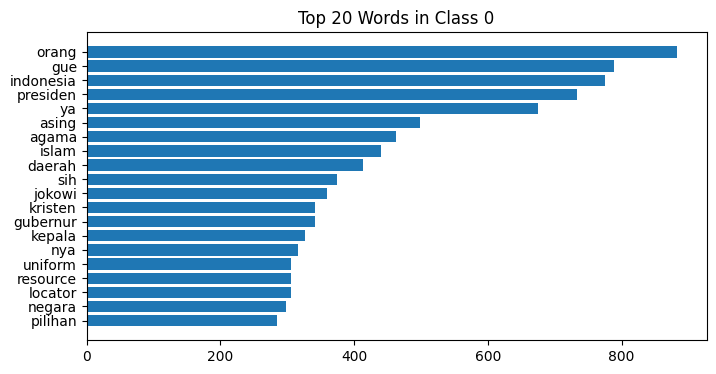

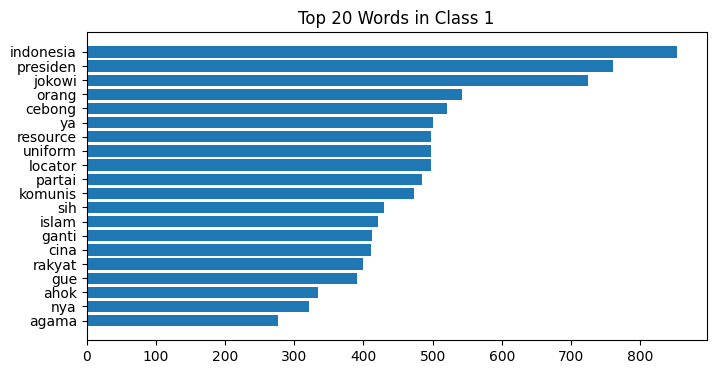

In [17]:
stopwords_id = stopwords.words('indonesian')

for sentiment in sorted(df['cyberbullying'].unique()):
    text = " ".join(df[df['cyberbullying'] == sentiment]['clean_text_bert'])
    
    vectorizer = CountVectorizer(stop_words=stopwords_id)
    X = vectorizer.fit_transform([text])
    freqs = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().flatten()
    }).sort_values('count', ascending=False).head(20)

    plt.figure(figsize=(8,4))
    plt.barh(freqs['word'], freqs['count'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 Words in Class {sentiment}')
    plt.show()

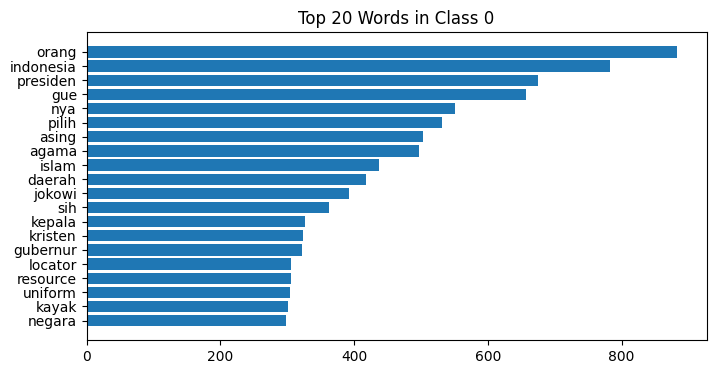

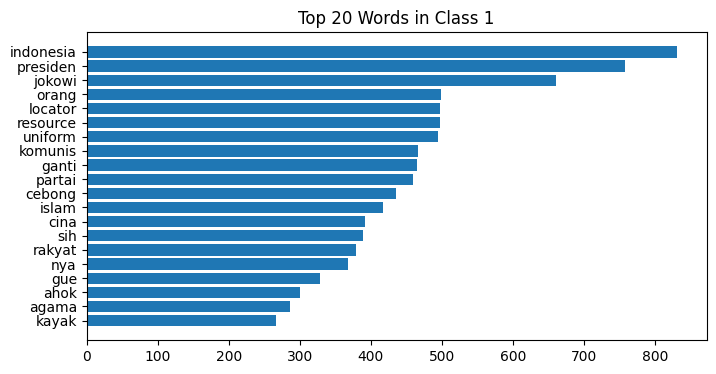

In [18]:
stopwords_id = stopwords.words('indonesian')

for sentiment in sorted(df['cyberbullying'].unique()):
    text = " ".join(df[df['cyberbullying'] == sentiment]['clean_text_ML_2'])
    
    vectorizer = CountVectorizer(stop_words=stopwords_id)
    X = vectorizer.fit_transform([text])
    freqs = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'count': X.toarray().flatten()
    }).sort_values('count', ascending=False).head(20)

    plt.figure(figsize=(8,4))
    plt.barh(freqs['word'], freqs['count'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 Words in Class {sentiment}')
    plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13017 entries, 0 to 13016
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             13017 non-null  object
 1   cyberbullying    13017 non-null  int64 
 2   length           13017 non-null  int64 
 3   clean_text_bert  13017 non-null  object
 4   clean_text_ML    13017 non-null  object
 5   clean_text_ML_2  13017 non-null  object
dtypes: int64(2), object(4)
memory usage: 610.3+ KB


In [20]:
import csv
df.to_csv("data/final_data_twitter.csv", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)